In [4]:
import pandas as pd
import anndata as ad
import scanpy as sc
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform, cdist
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.stats import *
from statsmodels.stats.multitest import multipletests


In [17]:
intensity_adata = sc.read_h5ad('/lab/solexa_weissman/reubens/projects/invivo_screens/imaging_data/061824_protein_intensity_adata.h5ad')
called_intensity = intensity_adata[intensity_adata.obs["singlet_name"] != ""]

z_scored_batch_intensity_collector = []
for batch in list(called_intensity.obs["batch"].unique()):
    #print(batch)
    batch_intensity = called_intensity[called_intensity.obs["batch"] == batch].copy()
    control_batch_intensity = batch_intensity[batch_intensity.obs["singlet_gene"] == "control"]
    batch_intensity.X = (batch_intensity.X - control_batch_intensity.X.mean(axis = 0)) / np.std(control_batch_intensity.X, axis = 0)
    z_scored_batch_intensity_collector.append(batch_intensity)

new_batch_ids = ['batch' + str(i) for i in range(1, len(z_scored_batch_intensity_collector) + 1)]
normalized_to_batch = ad.concat(z_scored_batch_intensity_collector, keys=new_batch_ids, join='outer', index_unique='-')


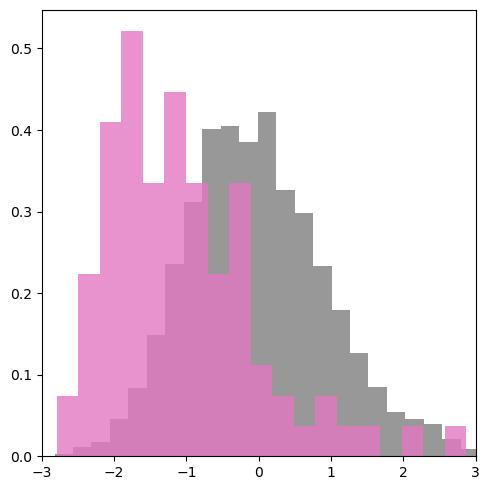

In [10]:
control_data = normalized_to_batch[normalized_to_batch.obs["singlet_gene"] == "control", "Gapdh"].X.flatten()
alb_data = normalized_to_batch[normalized_to_batch.obs["singlet_gene"] == "Gapdh", "Gapdh"].X.flatten()

color_control = sns.color_palette("tab10")[7]
color_alb = sns.color_palette("tab10")[6]

plt.figure(figsize=(5, 5))
plt.hist(control_data, bins=30, density=True, color=color_control, alpha=0.8, rwidth=1, linewidth=0)
plt.hist(alb_data, bins=19, density=True, color=color_alb, alpha=0.8, rwidth=1, linewidth=0)
plt.xlim(-3, 3)
plt.grid(False)
plt.tight_layout()

# Uncomment to save the figure
#plt.savefig(fixed_color_folder + "240620_gapdh_intensity_batchcorrected_edgefixed.pdf")

plt.show()

In [19]:
singlet_gene_counts = normalized_to_batch.obs["singlet_gene"].value_counts()
represented_30_genes = singlet_gene_counts[singlet_gene_counts > 30].index
called_intensity_df = normalized_to_batch.to_df()
called_intensity_df["singlet_gene"] = normalized_to_batch.obs["singlet_gene"]
mean_gene_intensity = called_intensity_df.groupby("singlet_gene").mean().loc[represented_30_genes]

mw_pvals_gene = pd.DataFrame(index=list(normalized_to_batch.var.index),
                        columns=list(normalized_to_batch.obs["singlet_gene"].unique()))
z_mean_gene = pd.DataFrame(index=list(normalized_to_batch.var.index),
                        columns=list(normalized_to_batch.obs["singlet_gene"].unique()))
cell_count_gene = pd.DataFrame(index=list(normalized_to_batch.var.index),
                        columns=list(normalized_to_batch.obs["singlet_gene"].unique()))

for channel in tqdm(list(normalized_to_batch.var.index)):
    channel_in_controls = list(normalized_to_batch[normalized_to_batch.obs["singlet_gene"] == "control", channel].X.flatten())
    for perturbation in list(set(represented_30_genes)):
        cell_count_gene.loc[channel, perturbation] = normalized_to_batch[normalized_to_batch.obs["singlet_gene"] == perturbation].shape[0]
        z_mean_gene.loc[channel, perturbation] = normalized_to_batch[normalized_to_batch.obs["singlet_gene"] == perturbation,channel].X.mean()
        mw_pvals_gene.loc[channel, perturbation] = mannwhitneyu(list(normalized_to_batch[normalized_to_batch.obs["singlet_gene"] == perturbation,channel].X.flatten()),
                 channel_in_controls, alternative='two-sided')[1]

corrected_p_values_gene = {}
mw_pvals_gene_T = mw_pvals_gene.T
for column in mw_pvals_gene_T.columns:
    p_values = mw_pvals_gene_T[column].values
    _, corrected_p, _, _ = multipletests(p_values, alpha=0.05, method='fdr_by')
    corrected_p_values_gene[column] = corrected_p

# Create a new DataFrame with the corrected p-values
corrected_mw_pvals_gene = pd.DataFrame(corrected_p_values_gene)
corrected_mw_pvals_gene.index = mw_pvals_gene_T.index

/tmp/ipykernel_2739988/2789315448.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_gene_intensity = called_intensity_df.groupby("singlet_gene").mean().loc[represented_30_genes]
100%|██████████| 18/18 [00:46<00:00,  2.59s/it]


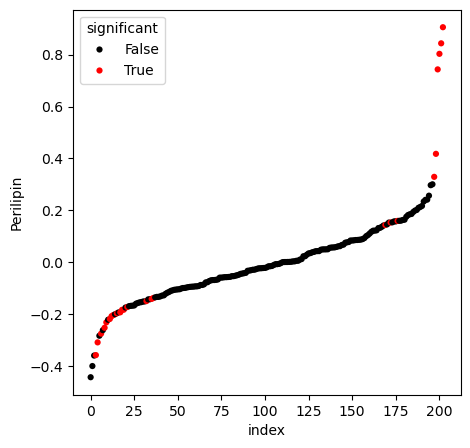

In [22]:
channel = "Perilipin"

p = pd.DataFrame(mean_gene_intensity[channel].sort_values()).reset_index().reset_index()
p["significant"] = (corrected_mw_pvals_gene.loc[p["singlet_gene"], channel] < 0.05).values

plt.figure(figsize = (5,5))
palette = {True: 'red', False: 'black'}

# Create the scatter plot
ax = sns.scatterplot(data=p, x="index", y=channel, edgecolor="None",
                     hue="significant", palette=palette, s = 20)
ax.grid(False)
plt.show()
